In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future
 
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')

In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [8]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [9]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [10]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [11]:
# Get userIDs, movie IDs and ratings as seperate arrays
user_ids = df['new_user_id']
movie_ids = df['new_movie_id']
ratings = df['rating'].values - 2.5

In [12]:
# Get the number of users and the number of movies
N = len(set(user_ids))
M = len(set(movie_ids))
# Set embedding dimension
D = 10

In [13]:
# make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim
    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)
    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)
    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [16]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [17]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [18]:
# convert to tensors
user_ids_t = torch.from_numpy(user_ids.values).long()
movie_ids_t = torch.from_numpy(movie_ids.values).long()
ratings_t = torch.from_numpy(ratings)

In [19]:
# make datasets
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain]
)
test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:]
)

In [20]:
# Data loaders
batch_size = 512
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [21]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs=1000):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for users, movies, targets in train_loader:
      targets = targets.view(-1, 1).float()
      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zer0 the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for users, movies, targets in test_loader:
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


  return train_losses, test_losses

In [22]:
# profile this using
%prun train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader,\
                                     epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([309])) that is different to the input size (torch.Size([309, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/25, Train Loss: 0.8170, Test Loss: 1.4609, Duration: 0:04:39.984849
Epoch 2/25, Train Loss: 0.7388, Test Loss: 1.4850, Duration: 0:04:41.142260
Epoch 3/25, Train Loss: 0.7225, Test Loss: 1.4928, Duration: 0:04:41.216316
Epoch 4/25, Train Loss: 0.7056, Test Loss: 1.5140, Duration: 0:04:40.102586
Epoch 5/25, Train Loss: 0.6926, Test Loss: 1.5162, Duration: 0:04:39.548249
Epoch 6/25, Train Loss: 0.6841, Test Loss: 1.5131, Duration: 0:04:40.158785
Epoch 7/25, Train Loss: 0.6781, Test Loss: 1.5379, Duration: 0:04:39.382502
Epoch 8/25, Train Loss: 0.6733, Test Loss: 1.5322, Duration: 0:04:39.160620
Epoch 9/25, Train Loss: 0.6696, Test Loss: 1.5413, Duration: 0:04:41.179920
Epoch 10/25, Train Loss: 0.6663, Test Loss: 1.5330, Duration: 0:04:39.498409
Epoch 11/25, Train Loss: 0.6635, Test Loss: 1.5479, Duration: 0:04:39.317032
Epoch 12/25, Train Loss: 0.6610, Test Loss: 1.5444, Duration: 0:04:39.858254
Epoch 13/25, Train Loss: 0.6587, Test Loss: 1.5530, Duration: 0:04:38.789346
Epoch 14

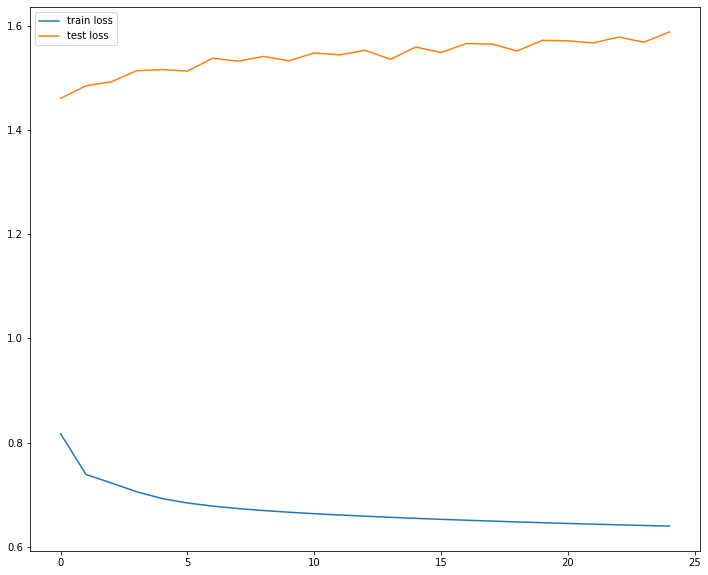

In [23]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()